In [752]:
import pylab as pl
import pandas as pd
import numpy as np
import scipy.stats

# Needed for data import workaround below
import io
import urllib2 as urllib

# Needed to get station borough
import requests
from geopy.geocoders import Nominatim
geolocator = Nominatim()

%pylab inline

Populating the interactive namespace from numpy and matplotlib


<b>Note</b>: Throughout this notebook, I will be using a significance level of 0.05

In [753]:
alpha = 0.05

<b>Structure</b>:<br>
1. trip duration of bikers that ride during the day vs. night<br>
2. age of bikers for trips originating in Manhattan and in Brooklyn

In [754]:
# Get data

# Had issues with compression='zip' in Pandas. Used example here:
# https://stackoverflow.com/questions/18885175/read-a-zipped-file-as-a-pandas-dataframe
# to work around it

# Spring data
r = urllib.urlopen('https://s3.amazonaws.com/tripdata/201704-citibike-tripdata.csv.zip')
df1 = pd.read_csv(io.BytesIO(r.read()), compression='zip')

# Summer data
r = urllib.urlopen('https://s3.amazonaws.com/tripdata/201707-citibike-tripdata.csv.zip')
df2 = pd.read_csv(io.BytesIO(r.read()), compression='zip', skiprows=0)

In [755]:
frames = [df1, df2.reset_index(drop=True)]
df = pd.concat(frames)
df = df.reset_index(drop=True)

In [756]:
# Prepare columns needed later

df['date'] = pd.to_datetime(df['starttime'])
df['age'] = 2017 - df['birth year']
df['hour'] = df['date'].dt.hour

In [757]:
df.head(1)

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,date,age,hour
0,195,2017-04-01 00:00:58,2017-04-01 00:04:14,217,Old Fulton St,40.703,-73.994,430,York St & Jay St,40.701,-73.987,25454,Subscriber,1966.000,1,2017-04-01 00:00:58,51.000,0


<b>Begin analysis of trip duration for day vs. night</b>

<b>Null hypothesis: There is no statistical difference in the duration distribution for daytime and nighttime rides - the samples are drawn from the same population.</b>

In [758]:
df_day = df

In [759]:
# Define night as 10 pm - 5 am
df_day['duration_day'] = df_day['tripduration'][(df_day['hour'] >= 5) & (df_day['hour'] < 22)]
df_day['duration_night'] = df_day['tripduration'][(df_day['hour'] >= 22) | (df_day['hour'] < 5)]

In [760]:
df_day.head(1)

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,date,age,hour,duration_day,duration_night
0,195,2017-04-01 00:00:58,2017-04-01 00:04:14,217,Old Fulton St,40.703,-73.994,430,York St & Jay St,40.701,-73.987,25454,Subscriber,1966.000,1,2017-04-01 00:00:58,51.000,0,nan,195.000


In [761]:
df_day.describe()

,tripduration,start station id,start station latitude,start station longitude,end station id,end station latitude,end station longitude,bikeid,birth year,gender,age,hour,duration_day,duration_night
count,3051003.000,3051003.000,3051003.000,3051003.000,3051003.000,3051003.000,3051003.000,3051003.000,2653735.000,3051003.000,2653735.000,3051003.000,2865686.000,185317.000
mean,1071.232,1341.362,40.736,-73.985,1338.781,40.736,-73.985,23190.309,1979.163,1.092,37.837,14.168,1064.421,1176.561
std,18602.419,1335.615,0.028,0.017,1335.518,0.037,0.046,4904.144,11.698,0.592,11.698,4.788,18346.058,22192.690
min,61.000,72.000,40.647,-74.017,72.000,0.000,-74.067,14529.000,1874.000,0.000,16.000,0.000,61.000,61.000
25%,389.000,359.000,40.718,-73.997,359.000,40.718,-73.997,18490.000,nan,1.000,nan,10.000,nan,nan
50%,664.000,484.000,40.737,-73.988,484.000,40.737,-73.988,25258.000,nan,1.000,nan,15.000,nan,nan
75%,1166.000,3137.000,40.755,-73.976,3137.000,40.755,-73.976,27631.000,nan,1.000,nan,18.000,nan,nan
max,9735948.000,3478.000,40.881,-73.897,3478.000,40.881,0.000,30337.000,2001.000,2.000,143.000,23.000,9735948.000,6624130.000


In [762]:
# drop NaN values
df_day['duration_day'].dropna(inplace= True)
df_day['duration_night'].dropna(inplace= True)

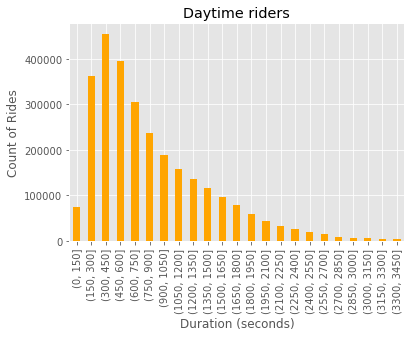

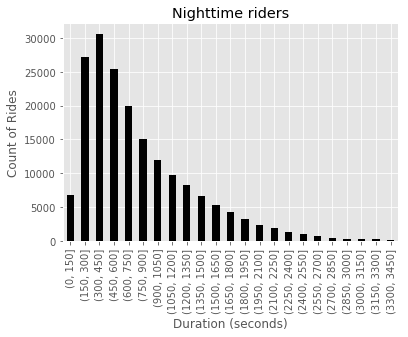

In [764]:
#Plot distributions
plt.style.use('ggplot')
bins = np.arange(0, 3500, 150)
axD = df_day.duration_day.groupby(pd.cut(df_day.duration_day, bins)).agg([count_nonzero]).plot(kind='bar', 
                                                                legend=False, color = 'orange')
axD.set_xlabel('Duration (seconds)')
axD.set_ylabel('Count of Rides')
axD.set_title("Daytime riders")

axN = df_day.duration_night.groupby(pd.cut(df_day.duration_night, bins)).agg([count_nonzero]).plot(kind='bar',
                                                                legend=False, color = 'black')
axN.set_title("Nighttime riders");
axN.set_xlabel('Duration (seconds)')
axN.set_ylabel('Count of Rides')

<b>Figure 1: Histograms of rides by trip duration in seconds for day vs. night</b><br>
Note: Current limit on trip duration is 30 minutes, with a charge for every 15 minutes above that; some higher values omitted

In [765]:
csD=df_day.duration_day.groupby(pd.cut(df_day.duration_day, bins)).agg([count_nonzero]).cumsum()

csN=df_day.duration_night.groupby(pd.cut(df_day.duration_night, bins)).agg([count_nonzero]).cumsum()

print (np.abs(csD / csD.max()-csN / csN.max()))

              count_nonzero
duration_day               
(0, 150]              0.011
(150, 300]            0.031
(300, 450]            0.037
(450, 600]            0.036
(600, 750]            0.036
(750, 900]            0.035
(900, 1050]           0.033
(1050, 1200]          0.030
(1200, 1350]          0.027
(1350, 1500]          0.022
(1500, 1650]          0.017
(1650, 1800]          0.012
(1800, 1950]          0.009
(1950, 2100]          0.007
(2100, 2250]          0.006
(2250, 2400]          0.004
(2400, 2550]          0.003
(2550, 2700]          0.002
(2700, 2850]          0.001
(2850, 3000]          0.001
(3000, 3150]          0.001
(3150, 3300]          0.000
(3300, 3450]          0.000


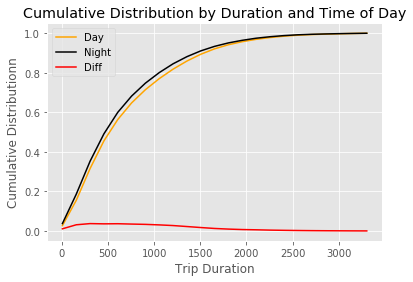

In [766]:
pl.plot(bins[:-1] + 5, csD / csD.max(), label = "Day", color = "Orange")
pl.plot(bins[:-1] + 5, csN / csN.max(), label = "Night", color = "Black")
pl.plot(bins[:-1] + 5, np.sqrt(csN / csN.max() - csD / csD.max())**2, 'k-',
        label = "Diff", color = "red")
pl.title("Cumulative Distribution by Duration and Time of Day")
pl.xlabel("Trip Duration")
pl.ylabel("Cumulative Distributionn")
pl.legend()

<b>Figure 2: Cumulative distribution of trip durations by day vs. night</b>

<b>Kolmogorov-Smirnov Test</b>

In [767]:
ks = scipy.stats.ks_2samp(df_day.duration_day, df_day.duration_night)
print(ks)

Ks_2sampResult(statistic=0.038959976851647676, pvalue=4.8355100592493917e-230)


In [594]:
if ks[1] <= alpha: # My significance level of p = 0.05
    print("We reject the null hypothesis.\n"\
          + "Kolmogorov-Smirnov statistic p-value of {:.4f} is less than my significance level of p = {:.4f}.\n".format(ks[1], alpha)\
          + "We do not accept that the two sample distributions (day vs. night rides) are significantly the same and were drawn from the same population.")
else:
        print("We do not reject the null hypothesis.\n"\
          + "Kolmogorov-Smirnov statistic p-value of {:.4f} is greater than my significance level of p = {:.4f}.\n".format(ks[1], alpha)\
          + "We accept that the two samples (day vs. night rides) are significantly the same and were drawn from the same population.")

We reject the null hypothesis.
Kolmogorov-Smirnov statistic p-value of 0.0000 is less than my significance level of p = 0.0500.
We do not accept that the two sample distributions (day vs. night rides) are significantly the same and were drawn from the same population.


<b>Now do the same for a 1/200th sample of the dataframe</b>

In [768]:
# Sample data frame to 1/200th
df_day_sample = df_day.sample(len(df_day)/200)
df_day_sample.head(2)

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,date,age,hour,duration_day,duration_night
1146059,676,2017-04-27 19:36:22,2017-04-27 19:47:38,435,W 21 St & 6 Ave,40.742,-73.994,2003,1 Ave & E 18 St,40.734,-73.981,29371,Subscriber,1985.000,1,2017-04-27 19:36:22,32.000,19,676.000,nan
757736,661,2017-04-18 16:20:52,2017-04-18 16:31:54,281,Grand Army Plaza & Central Park S,40.764,-73.974,267,Broadway & W 36 St,40.751,-73.988,28923,Subscriber,1979.000,1,2017-04-18 16:20:52,38.000,16,661.000,nan


In [769]:
ks2 = scipy.stats.ks_2samp(df_day_sample.duration_day[~np.isnan(df_day_sample.duration_day)], 
                           df_day_sample.duration_night[~np.isnan(df_day_sample.duration_night)])
print(ks2)

Ks_2sampResult(statistic=0.04830454205677365, pvalue=0.03550150580631941)


In [770]:
if ks2[1] <= alpha: # My significance level of p = 0.05
    print("We reject the null hypothesis.\n"\
          + "Kolmogorov-Smirnov statistic p-value of {:.4f} is less than my significance level of p = {:.4f}.\n".format(ks2[1], alpha)\
          + "We do not accept that the two sample distributions (day vs. night rides) are significantly the same and were drawn from the same population.")
else:
        print("We do not reject the null hypothesis.\n"\
          + "Kolmogorov-Smirnov statistic p-value of {:.4f} is more than my significance level of p = {:.4f}.\n".format(ks2[1], alpha)\
          + "We accept that the two samples (day vs. night rides) are significantly the same and were drawn from the same population.")

We reject the null hypothesis.
Kolmogorov-Smirnov statistic p-value of 0.0355 is less than my significance level of p = 0.0500.
We do not accept that the two sample distributions (day vs. night rides) are significantly the same and were drawn from the same population.


<b>Pearson's Correlation Test</b>

<b>Null hypothesis</b>: The samples of day rides and night rides come from uncorrelated data sets.<br>
Again, testing at significance level (alpha) of 0.05.

In [771]:
# Verify 1/200 sample is not too small
print(len(df_day))
print(len(df_day['duration_day']))
print(len(df_day['duration_night']))
print(len(df_day)/200)

3051003
2865686
185317
15255


In [772]:
# 1/200th samples from data frames, taken in as numpy arrays
np.random.seed(999)
day_array = np.random.choice(df_day['duration_day'], len(df_day)/200, replace=False)
night_array = np.random.choice(df_day['duration_night'], len(df_day)/200, replace=False)

In [773]:
# Sort arrays for Pearson's correlation test
day_array = np.sort(day_array)
night_array = np.sort(night_array)

In [774]:
# Get results
r_score = scipy.stats.pearsonr(day_array, night_array)
print(r_score)

(0.92919963546142936, 0.0)


In [775]:
if r_score[1] <= alpha: # My significance level of p = 0.05
    print("We reject the null hypothesis.\n"\
          + "Pearson correlation coefficent p-value of {:.4f} is less than my significance level of p = {:.4f}.\n".format(r_score[1], alpha)\
          + "We do not accept that the two data sets are uncorrelated.")
else:
        print("We do not reject the null hypothesis.\n"\
          + "Pearson correlation coefficent p-value of {:.4f} is more than my significance level of p = {:.4f}.\n".format(r_score[1], alpha)\
          + "We accept that the two data sets are uncorrelated")

We reject the null hypothesis.
Pearson correlation coefficent p-value of 0.0000 is less than my significance level of p = 0.0500.
We do not accept that the two data sets are uncorrelated.


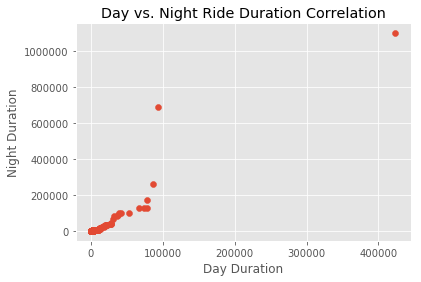

In [776]:
plt.scatter(day_array, night_array)
plt.title('Day vs. Night Ride Duration Correlation')
plt.xlabel('Day Duration')
plt.ylabel('Night Duration')

<b>Correlation Figure</b>:Simple scatter shows strong correlation between the day and night arrays

<b>Spearman's Test for Correlation</b>

<b>Null hypothesis</b>: The samples of day rides and night rides come from uncorrelated data sets.<br>
Testing at significance level (alpha) of 0.05.
<br><br>
<i>Using the same null hypothesis (biggest difference between Pearson and Spearman tests seems to be that Spearman's does not assume a normal distrbution)</i>

In [777]:
# Operating on my same reduced sorted arrays
sp = scipy.stats.spearmanr(day_array, night_array)
print(sp)

SpearmanrResult(correlation=0.99999933630741666, pvalue=0.0)


In [778]:
if sp[1] <= alpha: # My significance level of p = 0.05
    print("We reject the null hypothesis.\n"\
          + "Spearman correlation p-value of {:.4f} is less than my significance level of p = {:.4f}.\n".format(sp[1], alpha)\
          + "We do not accept that the two data sets are uncorrelated.")
else:
        print("We do not reject the null hypothesis.\n"\
          + "Spearman correlation p-value of {:.4f} is more than my significance level of p = {:.4f}.\n".format(sp[1], alpha)\
          + "We accept that the two data sets are uncorrelated")

We reject the null hypothesis.
Spearman correlation p-value of 0.0000 is less than my significance level of p = 0.0500.
We do not accept that the two data sets are uncorrelated.


<b>Let's do it all over again for age of riders by Manhattan vs. Brooklyn</b>

<b>Null hypothesis for K-S: There is no statistical difference in the age distribution for Manhattan and Brookiyn riders - the samples are drawn from the same population.</b>

In [779]:
df_age = df

In [780]:
# # Get borough name (Manhattan vs. Brooklyn) for stations - not that easy!
# # This part is reproducible but very slow so this block is commented out and the result 
# # dictionary is explicitly passed below

# # Get full list of stations from Citibike feed
# resp = requests.get('https://feeds.citibikenyc.com/stations/stations.json').json()

# # Pass station lat, long to dict
# test_dict = {}
# for elem in range(len(resp['stationBeanList'])):
#     test_dict[resp['stationBeanList'][elem]['id']] = [resp['stationBeanList'][elem]['latitude'],resp['stationBeanList'][elem]['longitude']]

# # Use geopy to get county (ie, borough) from lat/long - SLOW operation
# final_dict = {}
# for elem in test_dict.keys():
#     final_dict[elem] = geolocator.reverse(str(test_dict[elem][0]) + ", " + str(test_dict[elem][1])).raw['address']['county']

In [781]:
final_dict = {72: u'New York County',
 79: u'New York County',
 82: u'New York County',
 83: u'Kings County',
 116: u'New York County',
 119: u'Kings County',
 120: u'Kings County',
 127: u'New York County',
 128: u'New York County',
 143: u'Kings County',
 144: u'Kings County',
 146: u'New York County',
 150: u'New York County',
 151: u'New York County',
 152: u'New York County',
 153: u'New York County',
 157: u'Kings County',
 161: u'New York County',
 164: u'New York County',
 167: u'New York County',
 168: u'New York County',
 173: u'New York County',
 174: u'New York County',
 195: u'New York County',
 212: u'New York County',
 216: u'Kings County',
 217: u'Kings County',
 223: u'New York County',
 228: u'New York County',
 229: u'New York County',
 232: u'Kings County',
 236: u'New York County',
 237: u'New York County',
 238: u'New York County',
 239: u'Kings County',
 241: u'Kings County',
 242: u'Kings County',
 243: u'Kings County',
 244: u'Kings County',
 245: u'Kings County',
 248: u'New York County',
 249: u'New York County',
 251: u'New York County',
 252: u'New York County',
 253: u'New York County',
 254: u'New York County',
 257: u'New York County',
 258: u'Kings County',
 259: u'New York County',
 260: u'New York County',
 261: u'Kings County',
 262: u'Kings County',
 264: u'New York County',
 265: u'New York County',
 266: u'New York County',
 267: u'New York County',
 268: u'New York County',
 270: u'Kings County',
 274: u'Kings County',
 275: u'Kings County',
 276: u'New York County',
 278: u'Kings County',
 279: u'New York County',
 280: u'New York County',
 281: u'New York County',
 282: u'Kings County',
 284: u'New York County',
 285: u'New York County',
 289: u'Kings County',
 291: u'New York County',
 293: u'New York County',
 295: u'New York County',
 296: u'New York County',
 297: u'New York County',
 301: u'New York County',
 302: u'New York County',
 303: u'New York County',
 304: u'New York County',
 305: u'New York County',
 306: u'New York County',
 307: u'New York County',
 308: u'New York County',
 309: u'New York County',
 310: u'Kings County',
 311: u'New York County',
 312: u'New York County',
 313: u'Kings County',
 314: u'Kings County',
 315: u'New York County',
 316: u'New York County',
 317: u'New York County',
 319: u'New York County',
 320: u'New York County',
 321: u'Kings County',
 322: u'Kings County',
 323: u'Kings County',
 324: u'Kings County',
 325: u'New York County',
 326: u'New York County',
 327: u'New York County',
 328: u'New York County',
 330: u'New York County',
 331: u'New York County',
 332: u'New York County',
 334: u'New York County',
 335: u'New York County',
 336: u'New York County',
 337: u'New York County',
 339: u'New York County',
 340: u'New York County',
 341: u'New York County',
 342: u'New York County',
 343: u'Kings County',
 344: u'Kings County',
 345: u'New York County',
 346: u'New York County',
 347: u'New York County',
 349: u'New York County',
 350: u'New York County',
 351: u'New York County',
 353: u'Kings County',
 354: u'Kings County',
 355: u'New York County',
 356: u'New York County',
 357: u'New York County',
 358: u'New York County',
 359: u'New York County',
 360: u'New York County',
 361: u'New York County',
 362: u'New York County',
 363: u'New York County',
 364: u'Kings County',
 365: u'Kings County',
 366: u'Kings County',
 368: u'New York County',
 369: u'New York County',
 372: u'Kings County',
 373: u'Kings County',
 376: u'New York County',
 377: u'New York County',
 379: u'New York County',
 380: u'New York County',
 382: u'New York County',
 383: u'New York County',
 385: u'New York County',
 386: u'New York County',
 387: u'New York County',
 388: u'New York County',
 389: u'Kings County',
 390: u'Kings County',
 391: u'Kings County',
 392: u'Kings County',
 393: u'New York County',
 394: u'New York County',
 396: u'Kings County',
 397: u'Kings County',
 398: u'Kings County',
 399: u'Kings County',
 400: u'New York County',
 401: u'New York County',
 402: u'New York County',
 403: u'New York County',
 405: u'New York County',
 406: u'Kings County',
 407: u'Kings County',
 408: u'New York County',
 409: u'Kings County',
 410: u'New York County',
 411: u'New York County',
 412: u'New York County',
 414: u'New York County',
 415: u'New York County',
 416: u'Kings County',
 417: u'New York County',
 418: u'Kings County',
 419: u'Kings County',
 420: u'Kings County',
 421: u'Kings County',
 422: u'New York County',
 423: u'New York County',
 426: u'New York County',
 427: u'New York County',
 428: u'New York County',
 430: u'Kings County',
 432: u'New York County',
 433: u'New York County',
 434: u'New York County',
 435: u'New York County',
 436: u'Kings County',
 437: u'Kings County',
 438: u'New York County',
 439: u'New York County',
 440: u'New York County',
 441: u'New York County',
 442: u'New York County',
 443: u'Kings County',
 445: u'New York County',
 446: u'New York County',
 447: u'New York County',
 448: u'New York County',
 449: u'New York County',
 450: u'New York County',
 453: u'New York County',
 454: u'New York County',
 455: u'New York County',
 456: u'New York County',
 457: u'New York County',
 458: u'New York County',
 459: u'New York County',
 460: u'Kings County',
 461: u'New York County',
 462: u'New York County',
 465: u'New York County',
 466: u'New York County',
 467: u'Kings County',
 468: u'New York County',
 469: u'New York County',
 470: u'New York County',
 471: u'Kings County',
 472: u'New York County',
 473: u'New York County',
 474: u'New York County',
 476: u'New York County',
 477: u'New York County',
 478: u'New York County',
 479: u'New York County',
 480: u'New York County',
 481: u'Kings County',
 482: u'New York County',
 483: u'New York County',
 484: u'New York County',
 485: u'New York County',
 486: u'New York County',
 487: u'New York County',
 490: u'New York County',
 491: u'New York County',
 492: u'New York County',
 494: u'New York County',
 495: u'New York County',
 496: u'New York County',
 497: u'New York County',
 498: u'New York County',
 499: u'New York County',
 500: u'New York County',
 501: u'New York County',
 502: u'New York County',
 503: u'New York County',
 504: u'New York County',
 505: u'New York County',
 507: u'New York County',
 508: u'New York County',
 509: u'New York County',
 513: u'New York County',
 514: u'New York County',
 515: u'New York County',
 516: u'New York County',
 517: u'New York County',
 518: u'New York County',
 519: u'New York County',
 520: u'New York County',
 522: u'New York County',
 523: u'New York County',
 524: u'New York County',
 525: u'New York County',
 526: u'New York County',
 527: u'New York County',
 528: u'New York County',
 529: u'New York County',
 530: u'New York County',
 531: u'New York County',
 532: u'Kings County',
 533: u'New York County',
 534: u'New York County',
 536: u'New York County',
 537: u'New York County',
 539: u'Kings County',
 540: u'New York County',
 545: u'New York County',
 546: u'New York County',
 2000: u'Kings County',
 2001: u'Kings County',
 2002: u'Kings County',
 2003: u'New York County',
 2005: u'Kings County',
 2006: u'New York County',
 2008: u'New York County',
 2009: u'New York County',
 2010: u'New York County',
 2012: u'New York County',
 2021: u'New York County',
 2022: u'New York County',
 2023: u'New York County',
 3002: u'New York County',
 3016: u'Kings County',
 3041: u'Kings County',
 3042: u'Kings County',
 3043: u'Kings County',
 3044: u'Kings County',
 3046: u'Kings County',
 3047: u'Kings County',
 3048: u'Kings County',
 3049: u'Kings County',
 3050: u'Kings County',
 3052: u'Kings County',
 3053: u'Kings County',
 3054: u'Kings County',
 3055: u'Kings County',
 3056: u'Kings County',
 3057: u'Kings County',
 3058: u'Kings County',
 3059: u'Kings County',
 3060: u'Kings County',
 3061: u'Kings County',
 3062: u'Kings County',
 3063: u'Kings County',
 3064: u'Kings County',
 3065: u'Kings County',
 3066: u'Kings County',
 3067: u'Kings County',
 3068: u'Kings County',
 3069: u'Kings County',
 3070: u'Kings County',
 3071: u'Kings County',
 3072: u'Kings County',
 3073: u'Kings County',
 3074: u'Kings County',
 3075: u'Kings County',
 3076: u'Kings County',
 3077: u'Kings County',
 3078: u'Kings County',
 3080: u'Kings County',
 3081: u'Kings County',
 3082: u'Kings County',
 3083: u'Kings County',
 3085: u'Kings County',
 3086: u'Kings County',
 3087: u'Kings County',
 3088: u'Kings County',
 3090: u'Kings County',
 3091: u'Kings County',
 3092: u'Kings County',
 3093: u'Kings County',
 3094: u'Kings County',
 3095: u'Kings County',
 3096: u'Kings County',
 3100: u'Kings County',
 3101: u'Kings County',
 3102: u'Kings County',
 3103: u'Kings County',
 3105: u'Kings County',
 3106: u'Kings County',
 3107: u'Kings County',
 3108: u'Kings County',
 3109: u'Kings County',
 3110: u'Kings County',
 3112: u'Kings County',
 3113: u'Kings County',
 3115: u'Kings County',
 3116: u'Kings County',
 3117: u'Kings County',
 3118: u'Kings County',
 3119: u'Queens County',
 3120: u'Queens County',
 3121: u'Queens County',
 3122: u'Queens County',
 3123: u'Queens County',
 3124: u'Queens County',
 3125: u'Queens County',
 3126: u'Queens County',
 3127: u'Queens County',
 3128: u'Queens County',
 3129: u'Queens County',
 3130: u'Queens County',
 3131: u'New York County',
 3132: u'New York County',
 3134: u'New York County',
 3135: u'New York County',
 3136: u'New York County',
 3137: u'New York County',
 3139: u'New York County',
 3140: u'New York County',
 3141: u'New York County',
 3142: u'New York County',
 3143: u'New York County',
 3144: u'New York County',
 3145: u'New York County',
 3146: u'New York County',
 3147: u'New York County',
 3148: u'New York County',
 3150: u'New York County',
 3151: u'New York County',
 3152: u'New York County',
 3155: u'New York County',
 3156: u'New York County',
 3157: u'New York County',
 3158: u'New York County',
 3159: u'New York County',
 3160: u'New York County',
 3161: u'New York County',
 3162: u'New York County',
 3163: u'New York County',
 3164: u'Manhattan',
 3165: u'New York County',
 3166: u'New York County',
 3167: u'New York County',
 3168: u'New York County',
 3169: u'New York County',
 3170: u'New York County',
 3171: u'New York County',
 3172: u'New York County',
 3173: u'New York County',
 3175: u'New York County',
 3177: u'New York County',
 3178: u'New York County',
 3179: u'Kings County',
 3180: u'Kings County',
 3182: u'New York County',
 3183: u'Hudson County',
 3184: u'Hudson County',
 3185: u'Hudson County',
 3186: u'Hudson County',
 3187: u'Hudson County',
 3188: u'Hudson County',
 3189: u'Hudson County',
 3190: u'Hudson County',
 3191: u'Hudson County',
 3192: u'Hudson County',
 3193: u'Hudson County',
 3194: u'Hudson County',
 3195: u'Hudson County',
 3196: u'Hudson County',
 3198: u'Hudson County',
 3199: u'Hudson County',
 3200: u'Hudson County',
 3201: u'Hudson County',
 3202: u'Hudson County',
 3203: u'Hudson County',
 3205: u'Hudson County',
 3206: u'Hudson County',
 3207: u'Hudson County',
 3209: u'Hudson County',
 3210: u'Hudson County',
 3211: u'Hudson County',
 3212: u'Hudson County',
 3213: u'Hudson County',
 3214: u'Hudson County',
 3216: u'Hudson County',
 3217: u'Hudson County',
 3220: u'Hudson County',
 3221: u'Queens County',
 3223: u'New York County',
 3224: u'New York County',
 3225: u'Hudson County',
 3226: u'New York County',
 3231: u'New York County',
 3232: u'Kings County',
 3233: u'New York County',
 3235: u'New York County',
 3236: u'New York County',
 3238: u'New York County',
 3241: u'Kings County',
 3242: u'Kings County',
 3243: u'New York County',
 3244: u'New York County',
 3249: u'Kings County',
 3254: u'New York County',
 3255: u'New York County',
 3256: u'New York County',
 3258: u'New York County',
 3259: u'New York County',
 3260: u'New York County',
 3263: u'New York County',
 3267: u'Hudson County',
 3268: u'Hudson County',
 3269: u'Hudson County',
 3270: u'Hudson County',
 3271: u'Hudson County',
 3272: u'Hudson County',
 3273: u'Hudson County',
 3274: u'Hudson County',
 3275: u'Hudson County',
 3276: u'Hudson County',
 3277: u'Hudson County',
 3278: u'Hudson County',
 3279: u'Hudson County',
 3280: u'Hudson County',
 3281: u'Hudson County',
 3282: u'New York County',
 3283: u'New York County',
 3284: u'New York County',
 3285: u'New York County',
 3286: u'New York County',
 3288: u'New York County',
 3289: u'New York County',
 3290: u'New York County',
 3292: u'New York County',
 3293: u'New York County',
 3294: u'New York County',
 3295: u'New York County',
 3296: u'New York County',
 3297: u'Kings County',
 3298: u'Kings County',
 3300: u'Kings County',
 3301: u'Manhattan',
 3302: u'New York County',
 3303: u'Kings County',
 3304: u'Kings County',
 3305: u'New York County',
 3306: u'Kings County',
 3307: u'New York County',
 3308: u'Kings County',
 3309: u'New York County',
 3310: u'Kings County',
 3311: u'Kings County',
 3312: u'New York County',
 3313: u'Kings County',
 3314: u'New York County',
 3315: u'Kings County',
 3316: u'New York County',
 3317: u'Kings County',
 3318: u'New York County',
 3319: u'Kings County',
 3320: u'New York County',
 3321: u'Kings County',
 3322: u'Kings County',
 3323: u'New York County',
 3324: u'Kings County',
 3325: u'New York County',
 3326: u'Kings County',
 3327: u'New York County',
 3328: u'New York County',
 3329: u'Kings County',
 3330: u'Kings County',
 3331: u'New York County',
 3332: u'Kings County',
 3333: u'Kings County',
 3335: u'Kings County',
 3336: u'New York County',
 3337: u'Kings County',
 3338: u'New York County',
 3339: u'Kings County',
 3340: u'Kings County',
 3341: u'New York County',
 3342: u'Kings County',
 3343: u'New York County',
 3344: u'Kings County',
 3345: u'New York County',
 3346: u'Kings County',
 3347: u'Kings County',
 3348: u'Kings County',
 3349: u'Kings County',
 3350: u'New York County',
 3351: u'New York County',
 3352: u'Kings County',
 3353: u'Kings County',
 3354: u'Kings County',
 3355: u'New York County',
 3356: u'New York County',
 3357: u'New York County',
 3358: u'Kings County',
 3359: u'New York County',
 3360: u'New York County',
 3361: u'Kings County',
 3362: u'New York County',
 3363: u'New York County',
 3364: u'Kings County',
 3365: u'Kings County',
 3366: u'New York County',
 3367: u'New York County',
 3368: u'Kings County',
 3369: u'New York County',
 3370: u'New York County',
 3371: u'Kings County',
 3372: u'New York County',
 3373: u'Kings County',
 3374: u'New York County',
 3375: u'New York County',
 3376: u'New York County',
 3377: u'Kings County',
 3378: u'New York County',
 3379: u'New York County',
 3381: u'Kings County',
 3382: u'Kings County',
 3383: u'New York County',
 3384: u'Kings County',
 3386: u'Kings County',
 3387: u'New York County',
 3388: u'Kings County',
 3389: u'Kings County',
 3390: u'New York County',
 3391: u'New York County',
 3392: u'Kings County',
 3393: u'Kings County',
 3394: u'Kings County',
 3395: u'Kings County',
 3396: u'Kings County',
 3397: u'Kings County',
 3398: u'Kings County',
 3399: u'Kings County',
 3400: u'New York County',
 3401: u'Kings County',
 3402: u'Kings County',
 3403: u'Kings County',
 3404: u'Kings County',
 3405: u'Kings County',
 3407: u'Kings County',
 3408: u'Kings County',
 3409: u'Kings County',
 3410: u'Kings County',
 3411: u'Kings County',
 3412: u'Kings County',
 3413: u'Kings County',
 3414: u'Kings County',
 3415: u'Kings County',
 3416: u'Kings County',
 3417: u'Kings County',
 3418: u'Kings County',
 3419: u'Kings County',
 3420: u'Kings County',
 3421: u'Kings County',
 3422: u'Kings County',
 3423: u'Kings County',
 3424: u'New York County',
 3425: u'New York County',
 3427: u'New York County',
 3428: u'New York County',
 3429: u'Kings County',
 3430: u'Kings County',
 3431: u'New York County',
 3434: u'New York County',
 3435: u'New York County',
 3436: u'New York County',
 3437: u'New York County',
 3438: u'New York County',
 3440: u'Kings County',
 3443: u'New York County',
 3447: u'New York County',
 3449: u'Kings County',
 3452: u'Kings County',
 3453: u'Kings County',
 3454: u'Kings County',
 3455: u'Kings County',
 3456: u'Kings County',
 3457: u'New York County',
 3458: u'New York County',
 3459: u'New York County',
 3461: u'New York County',
 3462: u'New York County',
 3463: u'New York County',
 3466: u'New York County',
 3467: u'New York County',
 3469: u'Kings County',
 3472: u'New York County',
 3474: u'New York County',
 3476: u'Kings County',
 3477: u'Kings County',
 3478: u'Kings County',
 3479: u'New York County',
 3481: u'Hudson County',
 3486: u'Kings County',
 3489: u'New York County',
 3490: u'New York County',
 3491: u'New York County',
 3492: u'New York County',
 3493: u'New York County',
 3494: u'New York County',
 3495: u'New York County',
 3496: u'New York County',
 3497: u'New York County',
 3498: u'New York County',
 3499: u'New York County',
 3500: u'New York County',
 3501: u'New York County',
 3502: u'New York County',
 3503: u'New York County',
 3504: u'New York County',
 3505: u'New York County',
 3506: u'New York County',
 3507: u'New York County',
 3508: u'New York County',
 3509: u'New York County',
 3510: u'New York County',
 3511: u'Manhattan',
 3512: u'Queens County',
 3513: u'Queens County',
 3514: u'Queens County',
 3515: u'Queens County',
 3516: u'Queens County',
 3517: u'Queens County',
 3518: u'New York County',
 3519: u'Queens County',
 3520: u'New York County',
 3521: u'New York County',
 3522: u'Queens County',
 3523: u'Queens County',
 3524: u'Queens County',
 3525: u'Queens County',
 3526: u'Queens County',
 3527: u'New York County',
 3528: u'Queens County',
 3529: u'New York County',
 3530: u'Queens County',
 3531: u'New York County',
 3532: u'Queens County',
 3533: u'New York County',
 3534: u'New York County',
 3535: u'New York County',
 3536: u'New York County',
 3537: u'Kings County',
 3538: u'New York County',
 3539: u'New York County',
 3540: u'New York County',
 3541: u'New York County',
 3542: u'New York County',
 3543: u'New York County',
 3544: u'Kings County',
 3545: u'New York County',
 3546: u'Kings County',
 3547: u'New York County',
 3548: u'Kings County',
 3549: u'Kings County',
 3550: u'New York County',
 3551: u'New York County',
 3552: u'New York County',
 3553: u'New York County',
 3554: u'Queens County',
 3555: u'Queens County',
 3556: u'Queens County',
 3557: u'Queens County',
 3558: u'Kings County',
 3559: u'Queens County',
 3560: u'Queens County',
 3561: u'Queens County',
 3562: u'Kings County',
 3563: u'Queens County',
 3564: u'Queens County',
 3565: u'Queens County',
 3566: u'Queens County',
 3567: u'Queens County',
 3568: u'Queens County',
 3569: u'Kings County',
 3570: u'Queens County',
 3571: u'Kings County',
 3572: u'Queens County',
 3573: u'Queens County',
 3574: u'Kings County',
 3575: u'Queens County',
 3576: u'Kings County',
 3577: u'Queens County',
 3578: u'Kings County',
 3579: u'Kings County',
 3580: u'Kings County',
 3581: u'Kings County',
 3582: u'Kings County',
 3583: u'Kings County',
 3584: u'Kings County',
 3585: u'Kings County',
 3586: u'Queens County',
 3587: u'Kings County',
 3588: u'Queens County',
 3589: u'Queens County',
 3590: u'Kings County',
 3591: u'Queens County',
 3592: u'Queens County',
 3593: u'Queens County',
 3594: u'Kings County',
 3595: u'Queens County',
 3596: u'Kings County',
 3597: u'Queens County',
 3598: u'Queens County',
 3599: u'Kings County',
 3600: u'Queens County',
 3601: u'Kings County',
 3602: u'Queens County',
 3603: u'Queens County',
 3604: u'Kings County',
 3605: u'Queens County',
 3606: u'Queens County',
 3607: u'Queens County',
 3608: u'Queens County',
 3609: u'Queens County',
 3610: u'Queens County',
 3611: u'Queens County',
 3612: u'Queens County',
 3613: u'Queens County',
 3614: u'Queens County',
 3615: u'Queens County',
 3616: u'Queens County',
 3617: u'Queens County',
 3618: u'Queens County',
 3619: u'Queens County',
 3620: u'Queens County',
 3621: u'Queens County',
 3622: u'New York County',
 3623: u'New York County',
 3624: u'Queens County',
 3625: u'Queens County',
 3626: u'Queens County',
 3627: u'Queens County',
 3628: u'New York County',
 3629: u'New York County',
 3630: u'New York County',
 3631: u'Kings County',
 3632: u'New York County',
 3635: u'New York County',
 3637: u'Kings County',
 3638: u'Hudson County',
 3639: u'Hudson County',
 3640: u'Hudson County',
 3641: u'New York County',
 3642: u'New York County'}

In [783]:
# Map by dictionary
df['county'] = df['start station id'].map(final_dict)
df['county'].head()

0       Kings County
1    New York County
2    New York County
3    New York County
4       Kings County
Name: county, dtype: object

In [784]:
# New columns by borough/county
df_age['age_manhattan'] = df_age['age'][df_age['county'] == 'New York County']
df_age['age_brooklyn'] = df_age['age'][df_age['county'] == 'Kings County']

In [785]:
df_age.describe()

,tripduration,start station id,start station latitude,start station longitude,end station id,end station latitude,end station longitude,bikeid,birth year,gender,age,hour,duration_day,duration_night,age_manhattan,age_brooklyn
count,3051003.000,3051003.000,3051003.000,3051003.000,3051003.000,3051003.000,3051003.000,3051003.000,2653735.000,3051003.000,2653735.000,3051003.000,2865686.000,185317.000,2120821.000,447931.000
mean,1071.232,1341.362,40.736,-73.985,1338.781,40.736,-73.985,23190.309,1979.163,1.092,37.837,14.168,1064.421,1176.561,38.178,36.269
std,18602.419,1335.615,0.028,0.017,1335.518,0.037,0.046,4904.144,11.698,0.592,11.698,4.788,18346.058,22192.690,12.001,10.065
min,61.000,72.000,40.647,-74.017,72.000,0.000,-74.067,14529.000,1874.000,0.000,16.000,0.000,61.000,61.000,16.000,16.000
25%,389.000,359.000,40.718,-73.997,359.000,40.718,-73.997,18490.000,nan,1.000,nan,10.000,nan,nan,nan,nan
50%,664.000,484.000,40.737,-73.988,484.000,40.737,-73.988,25258.000,nan,1.000,nan,15.000,nan,nan,nan,nan
75%,1166.000,3137.000,40.755,-73.976,3137.000,40.755,-73.976,27631.000,nan,1.000,nan,18.000,nan,nan,nan,nan
max,9735948.000,3478.000,40.881,-73.897,3478.000,40.881,0.000,30337.000,2001.000,2.000,143.000,23.000,9735948.000,6624130.000,143.000,131.000


In [786]:
# drop NaN values
df_age['age_manhattan'].dropna(inplace= True)
df_day['age_brooklyn'].dropna(inplace= True)

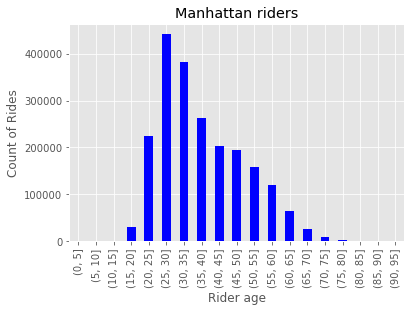

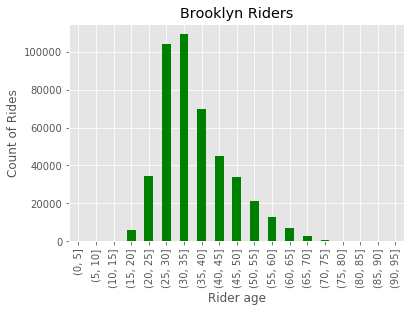

In [787]:
#Plot distributions
plt.style.use('ggplot')
bins = np.arange(0, 100, 5)
axM = df_age.age_manhattan.groupby(pd.cut(df_age.age_manhattan, bins)).agg([count_nonzero]).plot(kind='bar', 
                                                                legend=False, color = 'blue')
axM.set_xlabel('Rider age')
axM.set_ylabel('Count of Rides')
axM.set_title("Manhattan riders")

axB = df_age.age_brooklyn.groupby(pd.cut(df_age.age_brooklyn, bins)).agg([count_nonzero]).plot(kind='bar',
                                                                legend=False, color = 'green')
axB.set_title("Brooklyn Riders");
axB.set_xlabel('Rider age')
axB.set_ylabel('Count of Rides')

<b>Figure 1: Histograms of rides by rider age for Manhattan- vs. Brooklyn-originating trips</b><br>

In [788]:
csM=df_age.age_manhattan.groupby(pd.cut(df_age.age_manhattan, bins)).agg([count_nonzero]).cumsum()

csB=df_age.age_brooklyn.groupby(pd.cut(df_age.age_brooklyn, bins)).agg([count_nonzero]).cumsum()

print (np.abs(csM / csM.max()-csB / csB.max()))

               count_nonzero
age_manhattan               
(0, 5]                 0.000
(5, 10]                0.000
(10, 15]               0.000
(15, 20]               0.001
(20, 25]               0.029
(25, 30]               0.005
(30, 35]               0.059
(35, 40]               0.091
(40, 45]               0.096
(45, 50]               0.080
(50, 55]               0.053
(55, 60]               0.025
(60, 65]               0.009
(65, 70]               0.003
(70, 75]               0.001
(75, 80]               0.000
(80, 85]               0.000
(85, 90]               0.000
(90, 95]               0.000


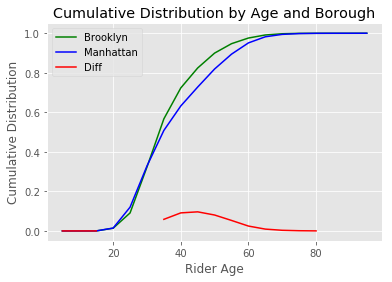

In [789]:
pl.plot(bins[:-1] + 5, csB / csB.max(), label = "Brooklyn", color = 'green')
pl.plot(bins[:-1] + 5, csM / csM.max(), label = "Manhattan", color = 'blue')
pl.plot(bins[:-1] + 5, np.sqrt(csB / csB.max() - csM / csM.max())**2, 'k-',
        label = "Diff", color = 'red')
pl.xlabel("Rider Age")
pl.ylabel("Cumulative Distribution")
pl.title("Cumulative Distribution by Age and Borough")
pl.legend()

<b>Figure 2: Cumulative distribution of rider age, Manhattan vs. Brooklyn</b>

<b>Kolmogorov-Smirnov Test</b>

In [790]:
ks3 = scipy.stats.ks_2samp(df_age.age_manhattan[~np.isnan(df_age.age_manhattan)],
                          df_age.age_brooklyn[~np.isnan(df_age.age_brooklyn)])
print(ks3)

Ks_2sampResult(statistic=0.11135522612506431, pvalue=0.0)


In [791]:
if ks3[1] <= alpha: # My significance level of p = 0.05
    print("We reject the null hypothesis.\n"\
          + "Kolmogorov-Smirnov statistic p-value of {:.4f} is less than my significance level of p = {:.4f}.\n".format(ks3[1], alpha)\
          + "We do not accept that the two sample distributions (Manhattan vs. Brooklyn rides) are significantly the same and were drawn from the same population.")
else:
        print("We do not reject the null hypothesis.\n"\
          + "Kolmogorov-Smirnov statistic p-value of {:.4f} is more than my significance level of p = {:.4f}.\n".format(ks3[1], alpha)\
          + "We accept that the two samples (Manhattan vs. Brooklyn rides) are significantly the same and were drawn from the same population.")

We reject the null hypothesis.
Kolmogorov-Smirnov statistic p-value of 0.0000 is less than my significance level of p = 0.0500.
We do not accept that the two sample distributions (Manhattan vs. Brooklyn rides) are significantly the same and were drawn from the same population.


<b>Again, same test for the 1/200th sample of the dataframe</b>

In [792]:
# Sample data frame to 1/200th
df_age_sample = df_age.sample(len(df_age)/200)
df_age_sample.head(2)

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,...,birth year,gender,date,age,hour,duration_day,duration_night,county,age_manhattan,age_brooklyn
2963373,89,2017-07-30 16:36:50,2017-07-30 16:38:19,383,Greenwich Ave & Charles St,40.735,-74.000,383,Greenwich Ave & Charles St,40.735,...,1990.000,2,2017-07-30 16:36:50,27.000,16,89.000,nan,New York County,27.000,nan
2688950,456,2017-07-26 09:06:30,2017-07-26 09:14:06,3365,3 St & 7 Ave,40.670,-73.978,3423,West Drive & Prospect Park West,40.661,...,1980.000,2,2017-07-26 09:06:30,37.000,9,456.000,nan,Kings County,nan,37.000


In [793]:
ks4 = scipy.stats.ks_2samp(df_age_sample.age_manhattan[~np.isnan(df_age_sample.age_manhattan)],
                          df_age_sample.age_brooklyn[~np.isnan(df_age_sample.age_brooklyn)])
print(ks4)

Ks_2sampResult(statistic=0.12904627102844993, pvalue=1.5684538014288085e-28)


In [794]:
if ks4[1] <= alpha: # My significance level of p = 0.05
    print("We reject the null hypothesis.\n"\
          + "Kolmogorov-Smirnov statistic p-value of {:.4f} is less than my significance level of p = {:.4f}.\n".format(ks4[1], alpha)\
          + "We do not accept that the two sample distributions (Manhattan vs. Brooklyn rides) are significantly the same and were drawn from the same population.")
else:
        print("We do not reject the null hypothesis.\n"\
          + "Kolmogorov-Smirnov statistic p-value of {:.4f} is more than my significance level of p = {:.4f}.\n".format(ks4[1], alpha)\
          + "We accept that the two samples (Manhattan vs. Brooklyn rides) are significantly the same and were drawn from the same population.")

We reject the null hypothesis.
Kolmogorov-Smirnov statistic p-value of 0.0000 is less than my significance level of p = 0.0500.
We do not accept that the two sample distributions (Manhattan vs. Brooklyn rides) are significantly the same and were drawn from the same population.


<b>Pearson's Correlation Test</b>

<b>Null hypothesis</b>: The samples of Manhattan rider ages and Brooklyn rider ages come from uncorrelated data sets.<br>
Testing at significance level (alpha) of 0.05.

In [795]:
# 1/200th samples from data frames, taken in as numpy arrays
np.random.seed(999)
man_array = np.random.choice(df_age.age_manhattan[~np.isnan(df_age.age_manhattan)], len(df_age)/200, replace=False)
brk_array = np.random.choice(df_age.age_brooklyn[~np.isnan(df_age.age_brooklyn)], len(df_age)/200, replace=False)

In [796]:
# Sort arrays for Pearson's correlation test
man_array = np.sort(man_array)
brk_array = np.sort(brk_array)

In [797]:
# Get results
r_score2 = scipy.stats.pearsonr(man_array, brk_array)
print(r_score2)

(0.99150751339117993, 0.0)


In [798]:
if r_score2[1] <= alpha: # My significance level of p = 0.05
    print("We reject the null hypothesis.\n"\
          + "Pearson correlation coefficent p-value of {:.4f} is less than my significance level of p = {:.4f}.\n".format(r_score2[1], alpha)\
          + "We do not accept that the two data sets are uncorrelated.")
else:
        print("We do not reject the null hypothesis.\n"\
          + "Pearson correlation coefficent p-value of {:.4f} is more than my significance level of p = {:.4f}.\n".format(r_score2[1], alpha)\
          + "We accept that the two data sets are uncorrelated")

We reject the null hypothesis.
Pearson correlation coefficent p-value of 0.0000 is less than my significance level of p = 0.0500.
We do not accept that the two data sets are uncorrelated.


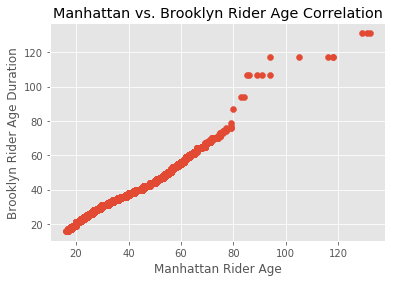

In [799]:
plt.scatter(man_array, brk_array)
plt.title('Manhattan vs. Brooklyn Rider Age Correlation')
plt.xlabel('Manhattan Rider Age')
plt.ylabel('Brooklyn Rider Age Duration')

<b>Spearman's Test for Correlation</b>

<b>Null hypothesis</b>: The samples of Manhattan rider ages and Brooklyn rider ages come from uncorrelated data sets.<br>
Testing at significance level (alpha) of 0.05.

In [800]:
sp2 = scipy.stats.spearmanr(man_array, brk_array)
print(sp2)

SpearmanrResult(correlation=0.99874703216022753, pvalue=0.0)


In [801]:
if sp2[1] <= alpha: # My significance level of p = 0.05
    print("We reject the null hypothesis.\n"\
          + "Spearman correlation p-value of {:.4f} is less than my significance level of p = {:.4f}.\n".format(sp2[1], alpha)\
          + "We do not accept that the two data sets are uncorrelated.")
else:
        print("We do not reject the null hypothesis.\n"\
          + "Spearman correlation p-value of {:.4f} is more than my significance level of p = {:.4f}.\n".format(sp2[1], alpha)\
          + "We accept that the two data sets are uncorrelated")

We reject the null hypothesis.
Spearman correlation p-value of 0.0000 is less than my significance level of p = 0.0500.
We do not accept that the two data sets are uncorrelated.
